# Summer analysis 2023 marginalization

Correlation between ndvi and marginalization

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [4]:
import sqlalchemy
print (sqlalchemy.__version__)

2.0.7


## Download data

### Municipality boundaries

In [3]:
mun_schema = 'metropolis'
mun_folder = 'metro_gdf'

city = 'Aguascalientes'

query = f"SELECT * FROM {mun_schema}.{mun_folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

AttributeError: 'OptionEngine' object has no attribute 'execute'

<AxesSubplot:>

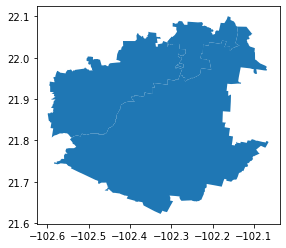

In [70]:
mun_gdf.plot()

## Download NDVI Data

In [74]:
ndvi_schema = 'raster_analysis'
ndvi_folder = 'ndvi_analysis_hex'

res = 8

query = f"SELECT * FROM {ndvi_schema}.{ndvi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(309, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,88498eace1fffff,"POLYGON ((-102.27404 21.81697, -102.27913 21.8...",8,0.092699,0.056485,0.075416,0.185093,0.048578,0.136515,-0.001392,Aguascalientes
1,88498eacadfffff,"POLYGON ((-102.26535 21.82823, -102.26585 21.8...",8,0.228987,0.125812,0.193252,0.445575,0.115533,0.330042,-0.001773,Aguascalientes


## Download NDMI Data

In [ ]:
ndmi_schema = 'raster_analysis'
ndmi_folder = 'ndmi_analysis_hex'

res = 8

query = f"SELECT * FROM {ndmi_schema}.{ndmi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndmi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(ndmi_gdf.shape)
ndmi_gdf.head(2)

## Data treatment

### NDVI processing

In [79]:
ndvi_gdf['ndvi_median_rango'] = np.nan
ndvi_gdf.loc[ndvi_gdf.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.4 )&
             (ndvi_gdf.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.2)&
             (ndvi_gdf.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.1)&
             (ndvi_gdf.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'


#Definir orden y convertir pct_inf_rango en categoría ordenada
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_gdf['ndvi_median_rango'] = pd.Categorical(ndvi_gdf['ndvi_median_rango'], categories=categories, ordered=True)

### Merging NDVI and NDMI

In [75]:
ndmi_gdf = ndmi_gdf.drop(columns=['geometry'])
hex_merged = ndvi_gdf.merge(ndmi_gdf, left_on='hex_id', right_on='hex_id_8')
hex_merged.head(2)

,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,88498eace1fffff,"POLYGON ((-102.27404 21.81697, -102.27913 21.8...",8,0.092699,0.056485,0.075416,0.185093,0.048578,0.136515,-0.001392,...,0.0,0.0,0.0,0.000000,0.000000,0.313972,0.082231,0.186888,124.706200,0.974158
1,88498eacadfffff,"POLYGON ((-102.26535 21.82823, -102.26585 21.8...",8,0.228987,0.125812,0.193252,0.445575,0.115533,0.330042,-0.001773,...,0.0,0.0,0.0,0.003525,0.260728,4.098095,0.300752,1.426299,125.846913,0.983069


## Data analysis
### Correlation analysis


Text(0.5, 1.0, 'Índice de vegetación')

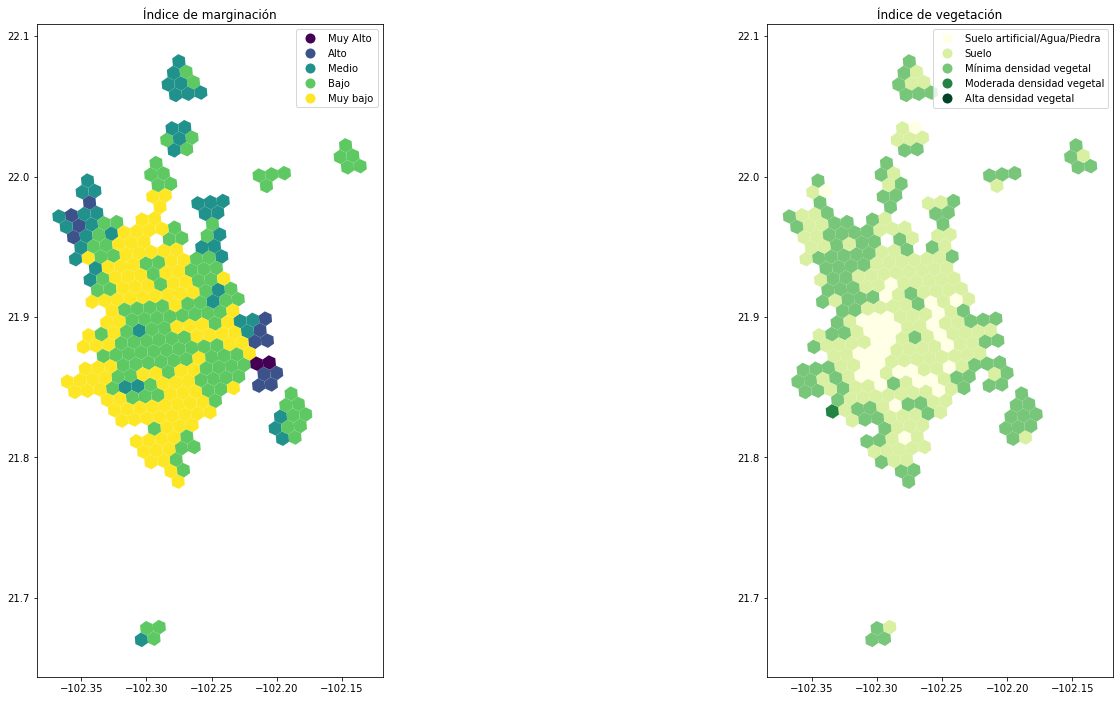

In [80]:
fig, ax = plt.subplots(1,2,figsize=(24,12))

hex_ind.plot('Grado_Marg', 'viridis', ax=ax[0], legend=True)
ndvi_gdf.plot('ndvi_median_rango', 'YlGn', ax=ax[1], legend=True)

ax[0].set_title('Índice de marginación')
ax[1].set_title('Índice de vegetación')

# Guardar gráficos
#plt.savefig("../../../output/figures/ndvi_marg/mar_ndvi_ags.jpg")

### Boxplots

In [81]:
#categorical data
cat_list = ['Muy Alto','Alto','Medio','Bajo','Muy bajo']

cat_size_order = CategoricalDtype(
    cat_list, 
    ordered=True)

hex_ind['Grado_Marg'] = hex_ind['Grado_Marg'].astype(cat_size_order)
hex_ind = hex_ind.sort_values('Grado_Marg')

In [82]:
hex_ind.loc[hex_ind.Grado_Marg.isna()]

,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020,Grado_Marg


Text(0, 0.5, 'Índice de vegetación')

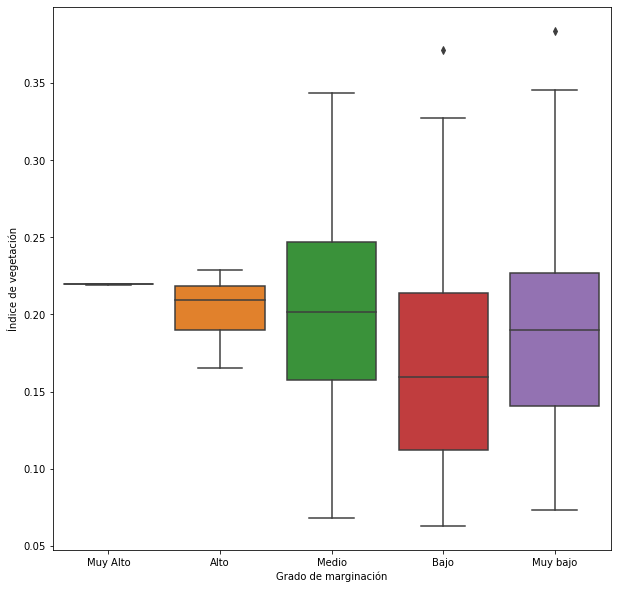

In [83]:
fig, ax = plt.subplots(figsize=(10,10))

sns.boxplot(x=np.array(hex_ind.Grado_Marg) , y=np.array(hex_ind.ndvi_median), ax=ax)

plt.xlabel('Grado de marginación')
plt.ylabel('Índice de vegetación')

#Para plotear figuras quitar # 
#plt.savefig("../../../output/figures/ndvi_marg/mar_boxplot_ags.jpg")

## Relación población_empleo

In [84]:
hex_ind['ndvi_marg'] = hex_ind['ndvi_median'] / hex_ind['imn_2020']

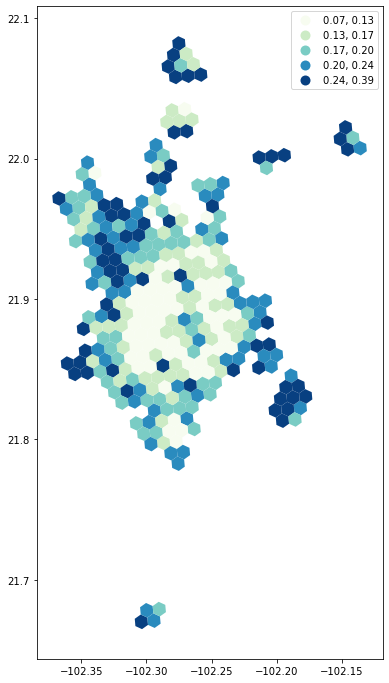

In [85]:
fig,ax = plt.subplots(figsize=(24,12))
hex_ind.plot('ndvi_marg', 'GnBu', scheme='quantiles', legend=True, ax=ax)

plt.savefig("../../../output/figures/ndvi_marg/rel_marg_ndvi_ags.jpg")